<a href="https://colab.research.google.com/github/sumanyurosha/Hands-on-ML/blob/main/Chapter2/Housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# **Get the Data**


## **Download the data**

In [123]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "/datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [124]:
fetch_housing_data()

In [125]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_file = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_file)

## **Take a quick look at the Data Structure**

In [126]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [127]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [128]:
# all attributes are numerical except ocean_proximity
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [129]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


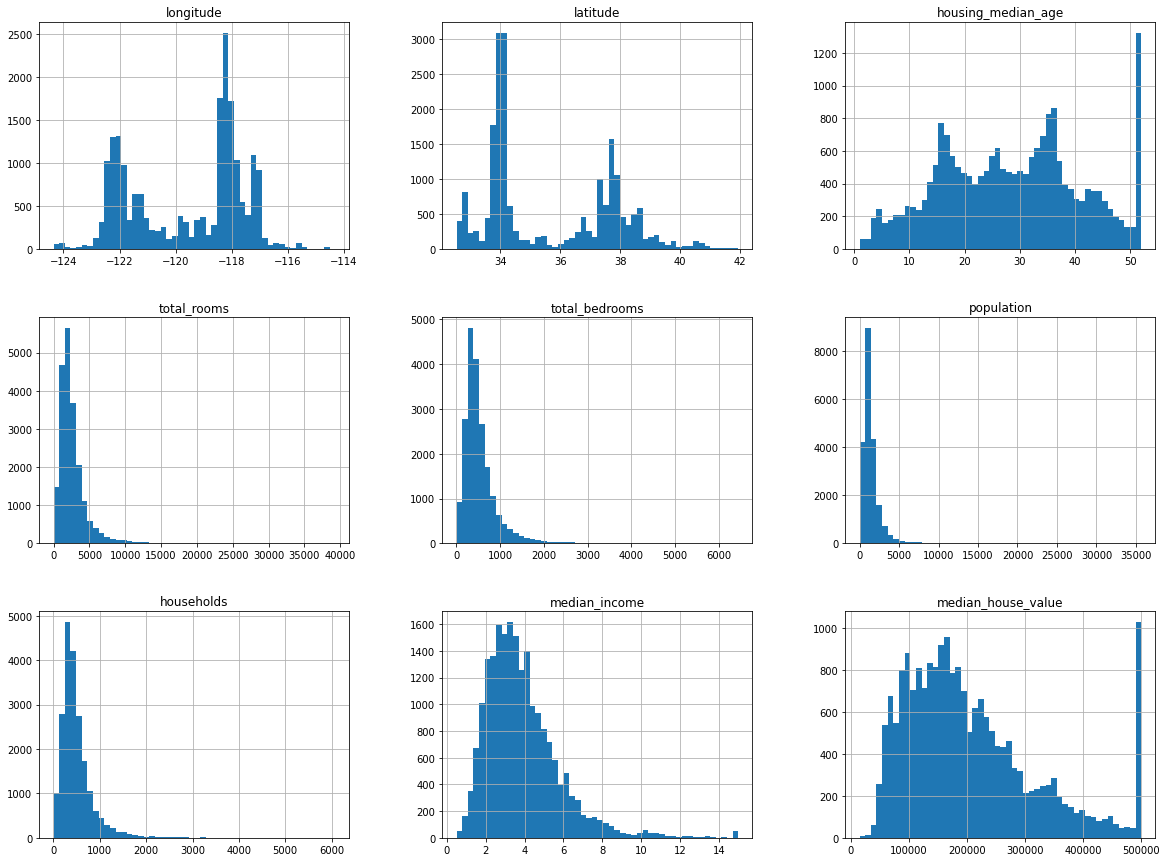

In [130]:
import matplotlib.pyplot as plt
%matplotlib inline

housing.hist(bins=50, figsize=(20, 15))
plt.show()

## **Create a Test Set**

In [131]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_size]
    train_indices = shuffled_indices[test_size:]
    
    return data.iloc[train_indices], data.iloc[test_indices]

In [132]:
train_set, test_set = split_train_test(housing, 0.2)

print(len(train_set))
print(len(test_set))

16512
4128


In [133]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test(data, test_ratio, id_column):
    ids = data[id_column]
    test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~test_set], data.loc[test_set]


In [134]:
housing_with_id = housing.reset_index() # adds index column
train_set, test_set = split_train_test(housing_with_id, 0.2, "index")

In [135]:
print(len(train_set))
print(len(test_set))

16512
4128


In [136]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [137]:
print(len(train_set))
print(len(test_set))

16512
4128


In [138]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0, 1.5, 3, 4.5, 6, np.inf],
                               labels=[1, 2, 3, 4, 5])

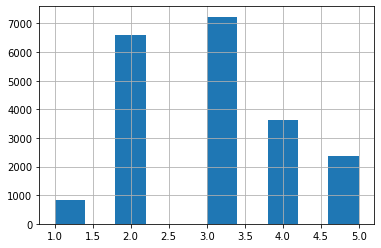

In [139]:
housing["income_cat"].hist()

In [140]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [141]:
strat_test_set["income_cat"].value_counts(normalize=True)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [142]:
housing["income_cat"].value_counts(normalize=True)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [143]:
# Now you should remove the income_cat attribute so that the data is back to its
# original state

for set_ in (strat_train_set, strat_test_set):
    set_.drop(["income_cat"], axis=1, inplace=True)

# **Discover and Visualize the Data to Gain Insights**

In [144]:
housing = strat_train_set.copy()

In [145]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


## **Visualizing Geaographical Data**

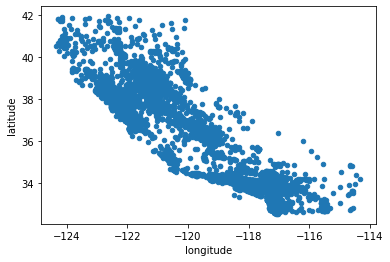

In [146]:
housing.plot(kind="scatter", x="longitude", y="latitude")

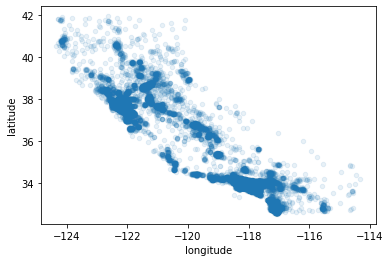

In [147]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

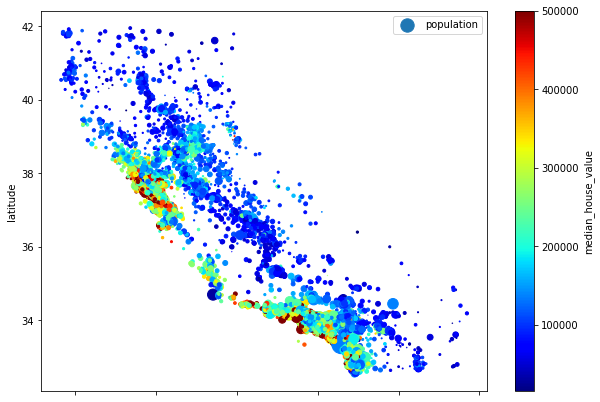

In [148]:
housing.plot(kind="scatter", x="longitude", y="latitude", 
             s=housing["population"]/100, label="population", figsize=(10, 7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()

## **Looking for Correlations**

In [149]:
# correlation is a statistical measure that expresses the extend two variables
# are linearly related(they change together at a constant rate)
corr_matrix = housing.corr()

In [150]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

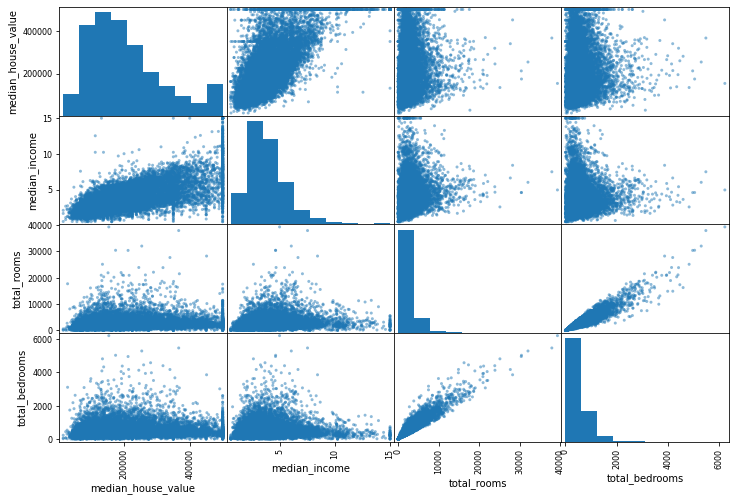

In [151]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "total_bedrooms"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

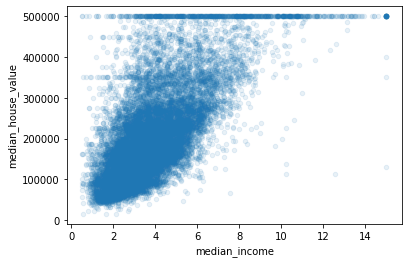

In [152]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

## **Experimenting with Attribute Combinations**

In [153]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

In [154]:
corr_matrix = housing.corr()

In [155]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

# **Prepare the Data for Machine Learning Algorithms**

In [156]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## **Data Cleaning**

In [157]:
# dropping the rows with missing values
housing.dropna(subset=["total_bedrooms"])

# dropping the entire column
housing.drop("total_bedrooms", axis=1)

# replacing the value with 0 or mean/median
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)

In [158]:
from sklearn.impute import SimpleImputer

# imputer calculates the mean of all the numerical attributes
imputer = SimpleImputer(strategy="median")

In [159]:
housing_num = housing.drop("ocean_proximity", axis=1)

imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [160]:
# it is better to save all the median values here, so that if in future any
# column has missing values we can use this.
print(imputer.statistics_)

print(housing_num.median().values)

[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]
[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]


In [161]:
# filling all the missing values
X = imputer.transform(housing_num)

In [162]:
# putting it back into pandas DataFrame as X is a numpy n-d array
housing_tr = pd.DataFrame(X, columns=housing_num.columns, 
                          index=housing_num.index)

In [163]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


## **Handling Text and Categorical Values**

In [164]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [165]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [166]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [167]:
# there is one problem with above approach, ML algos sometimes think that two nearby values are more related then the far ones.
# For Ex: (Very Bad, Bad, Good, Very Good) here the assumption is right but in our case, it is wrong.
# 0 and 4 are more related than 0 and 1. We use one hot encoding in such scenarios

from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
# fit_transform() = fit() + transform() and it is faster than the latter
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [168]:
# to see the values in sparse matrix, use toarray()
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [169]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## **Custom Transformers**

In [170]:
# creating your own custom transformer

from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):  # no *args or **kwargs here
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[rooms_per_household, population_per_household]


attr_adder = CombinedAttributesAdder()
housing_extra_attribs = attr_adder.transform(housing.values)

In [171]:
housing_extra_attribs

array([[4.625368731563422, 2.094395280235988, 0.22385204081632654],
       [6.008849557522124, 2.7079646017699117, 0.15905743740795286],
       [4.225108225108225, 2.0259740259740258, 0.24129098360655737],
       ...,
       [6.34640522875817, 2.742483660130719, 0.1796086508753862],
       [5.50561797752809, 3.808988764044944, 0.19387755102040816],
       [4.843505477308295, 1.9859154929577465, 0.22035541195476574]],
      dtype=object)

## **Transformation Pipelines**

In [172]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# helps to combine a sequence of transformations in one place
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("attribs_adder", CombinedAttributesAdder()),
    ("std_scaler", StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [173]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

# we can also apply columnwise transformations using ColumnTransformer
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)

In [174]:
housing_prepared

array([[-0.31205452, -0.08649871,  0.15531753, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.21768338, -0.03353391, -0.83628902, ...,  0.        ,
         0.        ,  0.        ],
       [-0.46531516, -0.09240499,  0.4222004 , ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.3469342 , -0.03055414, -0.52177644, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.02499488,  0.06150916, -0.30340741, ...,  0.        ,
         0.        ,  0.        ],
       [-0.22852947, -0.09586294,  0.10180567, ...,  0.        ,
         1.        ,  0.        ]])

# **Select and Train a Model**

## **Training and Evaluating on Training Set**

In [175]:
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression()
linear_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [176]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]

some_data_prepared = full_pipeline.transform(some_data)

print("Predictions: ", linear_reg.predict(some_data_prepared))
print("Labels: ", list(some_labels))

Predictions:  [235525.2506196  271153.14527077 233092.22170124 121802.6174826
 231539.2677509 ]
Labels:  [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [177]:
from sklearn.metrics import mean_squared_error

housing_predictions = linear_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_predictions, housing_labels)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

94520.15723494628

In [178]:
# using a better model to improve on our root mean sqaure error
# Decision Trees is a strong algo, capable of learning non-linear relationships 
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

tree_predicted = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(tree_predicted, housing_labels)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

## **Better Evaluation using Cross Validation**

In [179]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, 
                         scoring="neg_mean_squared_error", cv=10)

# the scoring is done using a utility function(greater is better) rather than
# a cost function(lesser is better), so we get a negative value
tree_rmse_scores = np.sqrt(-scores)

In [180]:
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Std: ", scores.std())

display_scores(tree_rmse_scores)

Scores:  [103672.49867916 104420.72486192 108287.99143984 107527.89177787
 105486.4392417  107682.65481432 100696.85231046 106909.87033642
 105441.91798055 103873.18160096]
Mean:  105400.00230431973
Std:  2208.20926298895
